In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.stats import kstest

from nba_api.stats.endpoints import playergamelog, playerprofilev2
from nba_api.stats.static import players

In [ ]:
"""
Fantasy Rules:

1 Point (2*(FG-3P) + 3*(3P) + FT) = 0.5 fpts
1 Rebound (TRB) = 1 fpts
1 Assist (AST) = 1 fpts
1 Steal (STL) = 2 fpts
1 Block (BLK) = 2 fpts
1 Turnover (TOV) = -1 fpts

Extra 0.5 fpts for every 3 Pointer (3P)
Extra 1 fpts for a double double
Extra 2 fpts for a triple double (3, since a triple double is also a double double)
"""

In [3]:
def calculate_fpts(row):
    
    pts = 2*(row['FG'] - row['3P']) + 3*row['3P'] + row['FT']
    rebs = row['TRB']
    asts = row['AST']
    stls = row['STL']
    blks = row['BLK']
    tovs = row['TOV']

    fpts = (0.5*pts) + 2*(stls + blks) + (rebs + asts) - tovs + 0.5*(row['3P'])

    stats = [pts, rebs, asts, stls, blks]
    count_doubles = 0
    for stat in stats:
        if stat >= 10:
            count_doubles += 1

    if count_doubles > 1:
        fpts += 1 # double double
    if count_doubles > 2:
        fpts += 2 # triple double

    return fpts

In [5]:
df_vw = pd.read_csv('/Users/maxmandel/Downloads/wemby_2425_stats.csv')
df_ae = pd.read_csv('/Users/maxmandel/Downloads/antedwards_2425_stats.csv')
df_ki = pd.read_csv('/Users/maxmandel/Downloads/kyrieirving_2425_stats.csv')
df_lb = pd.read_csv('/Users/maxmandel/Downloads/lameloball_2425_stats.csv')
df_jb = pd.read_csv('/Users/maxmandel/Downloads/jaylenbrown_2425_stats.csv')
df_lj = pd.read_csv('/Users/maxmandel/Downloads/lebron_2425_stats.csv')
df_jb = pd.read_csv('/Users/maxmandel/Downloads/jimmybutler_2425_stats.csv')
df_df = pd.read_csv('/Users/maxmandel/Downloads/fox_2425_stats.csv')
df_kp = pd.read_csv('/Users/maxmandel/Downloads/porzingis_2425_stats.csv')
df_ty = pd.read_csv('/Users/maxmandel/Downloads/traeyoung_2425_stats.csv')
df_dm = pd.read_csv('/Users/maxmandel/Downloads/dmitch_2425_stats.csv')
df_iz = pd.read_csv('/Users/maxmandel/Downloads/zubac_2425_stats.csv')
df_nv = pd.read_csv('/Users/maxmandel/Downloads/vuc_2425_stats.csv')

player_data = {}
player_data['Victor Wembanyama'] = df_vw
player_data['Anthony Edwards'] = df_ae
player_data['Kyrie Irving'] = df_ki
player_data['Lamelo Ball'] = df_lb
player_data['Jaylen Brown'] = df_jb
player_data['Lebron James'] = df_lj
player_data['Jimmy Butler'] = df_jb
player_data["De'Aaron Fox"] = df_df
player_data['Kristaps Porzingis'] = df_kp
player_data['Trae Young'] = df_ty
player_data['Donovan Mitchell'] = df_dm
player_data['Ivica Zubac'] = df_iz

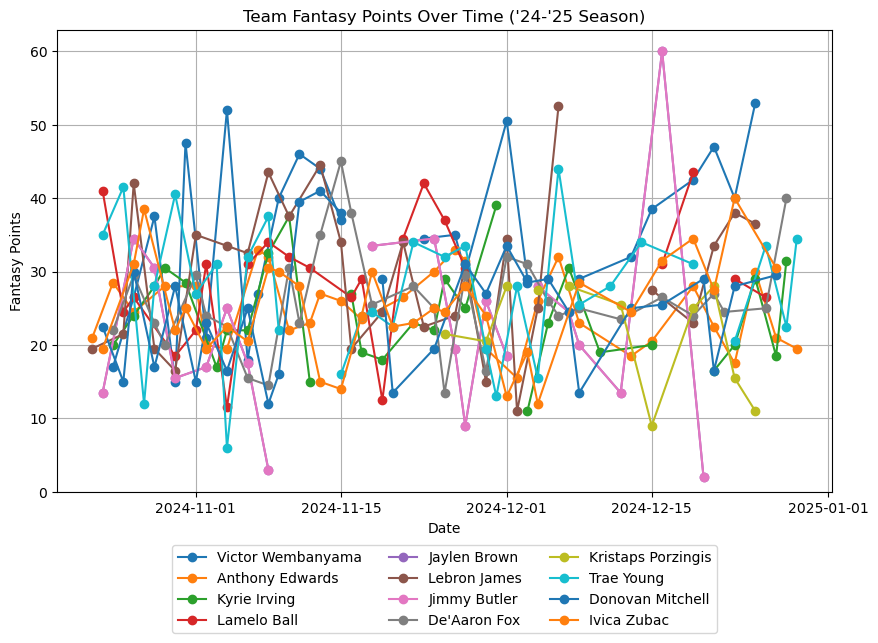

In [7]:
plt.figure(figsize=(10, 6))

all_fpts = []

for player, df in player_data.items():
    
    new_df = pd.DataFrame(columns=["DATE", "FPTS"])
    for index, row in df.iterrows():
        
        game_date = row['Date']
        fpts = calculate_fpts(row)
        if (fpts == fpts): # exclude NaN vals
            all_fpts.append(fpts)
        new_df.loc[len(new_df)] = [game_date, fpts]

    new_df['DATE'] = pd.to_datetime(new_df['DATE'], format="%m/%d/%y")

    new_df.set_index("DATE", inplace=True)
    plt.plot(new_df.index, new_df["FPTS"], marker='o', label=player)
    
plt.title("Team Fantasy Points Over Time ('24-'25 Season)")
plt.xlabel("Date")
plt.ylabel("Fantasy Points")
plt.ylim(bottom=0)
plt.grid(True)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

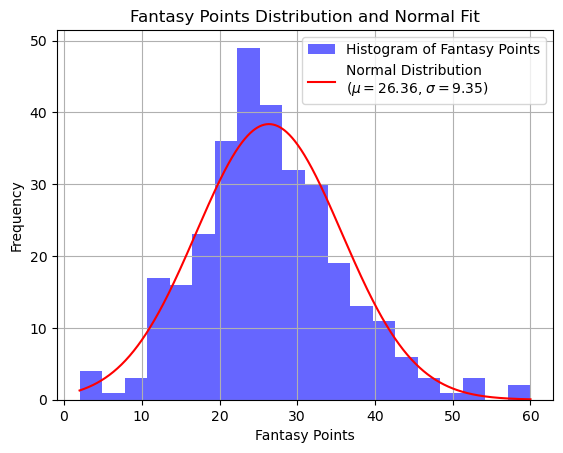

In [9]:
counts, bins, _ = plt.hist(all_fpts, bins=20, alpha=0.6, color='blue', label="Histogram of Fantasy Points")

mu = np.mean(all_fpts)
sigma = np.std(all_fpts)

x = np.linspace(min(bins), max(bins), 1000)

bin_width = bins[1] - bins[0]
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
pdf_scaled = pdf * len(all_fpts) * bin_width

plt.plot(x, pdf_scaled, label=f"Normal Distribution\n($\\mu={mu:.2f}$, $\\sigma={sigma:.2f}$)", color="red")

plt.title("Fantasy Points Distribution and Normal Fit")
plt.xlabel("Fantasy Points")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


In [11]:
def player_gamelogs(player_name): # just current season

    player_info = players.find_players_by_full_name(player_name)[0]
    player_id = player_info['id']

    return playergamelog.PlayerGameLog(player_id).get_data_frames()[0]

In [13]:
def get_player_gamelogs_all_seasons(player_name):
    
    player_info = players.find_players_by_full_name(player_name)
    if not player_info:
        raise ValueError(f"Player {player_name} not found.")
    
    player_id = player_info[0]['id']
    
    # Fetch player profile to determine rookie season
    profile = playerprofilev2.PlayerProfileV2(player_id=player_id)
    seasons_stats = profile.season_totals_regular_season.get_data_frame()
    rookie_season = int(seasons_stats['SEASON_ID'].min()[:4])
    current_season = int(seasons_stats['SEASON_ID'].max()[:4]) + 1

    seasons = [f"{year}-{str(year + 1)[-2:]}" for year in range(rookie_season, current_season)]
    
    # Fetch game logs for each season
    all_season_gamelogs = []
    for season in seasons:
        try:
            gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season)
            season_df = gamelog.get_data_frames()[0]
            season_df['SEASON'] = season
            all_season_gamelogs.append(season_df)
        except Exception as e:
            print(f"Error retrieving data for season {season}: {e}")

    # Combine all DataFrames
    if all_season_gamelogs:
        return pd.concat(all_season_gamelogs, ignore_index=True)
    else:
        return pd.DataFrame()

In [15]:
def calculate_fantasy_points(row):
    
    points = row['PTS'] * 0.5
    rebounds = row['REB']
    assists = row['AST']
    steals = row['STL'] * 2
    blocks = row['BLK'] * 2
    turnovers = row['TOV'] * -1
    threes_made = row['FG3M'] * 0.5

    fantasy_points = points + rebounds + assists + steals + blocks + turnovers + threes_made

    stat_categories = sum(stat >= 10 for stat in [row['PTS'], row['REB'], row['AST'], row['STL'], row['BLK']])
    if stat_categories >= 2:
        fantasy_points += 1  # Double-double bonus
    if stat_categories >= 3:
        fantasy_points += 2  # Triple-double bonus (includes double-double bonus)

    return fantasy_points


In [85]:
def get_all_fpts(player_name):
    
    df = get_player_gamelogs_all_seasons(player_name)
    all_fpts = []
    for _, row in df.iterrows():
        fpts = calculate_fantasy_points(row)
        all_fpts.append(fpts)
    return len(all_fpts), all_fpts

def viz_player_distribution(player_name):
    
    num, all_fpts = get_all_fpts(player_name)
    plt.hist(all_fpts, bins=int(np.sqrt(num) + 1), alpha=0.6, color='blue', label=player_name)
    plt.title("Fantasy Points Distribution")
    plt.xlabel("Fantasy Points")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend()
    plt.show()

def viz_multiple_players_distributions(player_name_arr):

    fpts_arrs = []
    for player_name in player_name_arr:
        num, all_fpts = get_all_fpts(player_name)
        plt.hist(all_fpts, bins=int(np.sqrt(num) + 1), alpha=0.3, label=player_name)
    
    plt.title("Fantasy Points Distributions By Player")
    plt.xlabel("Fantasy Points")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.show()
    

Error retrieving data for season 2020-21: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


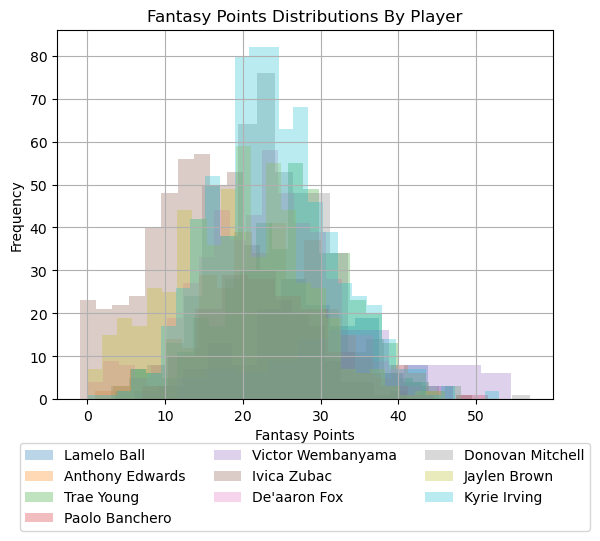

In [87]:
player_names = ["Lamelo Ball", "Anthony Edwards", "Trae Young", "Paolo Banchero", "Victor Wembanyama", "Ivica Zubac", "De'aaron Fox", "Donovan Mitchell", "Jaylen Brown", "Kyrie Irving"]
viz_multiple_players_distributions(player_names)

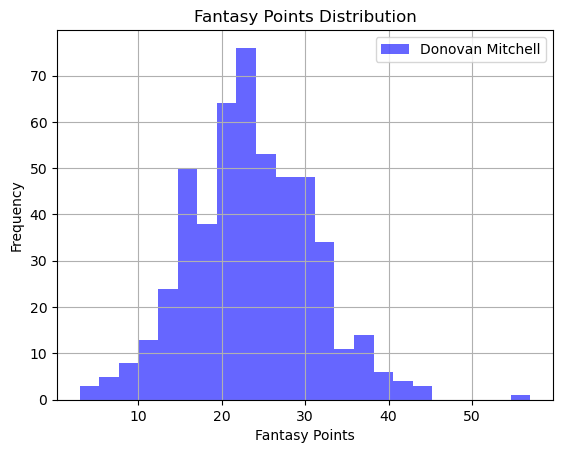

In [21]:
viz_player_distribution("Donovan Mitchell")

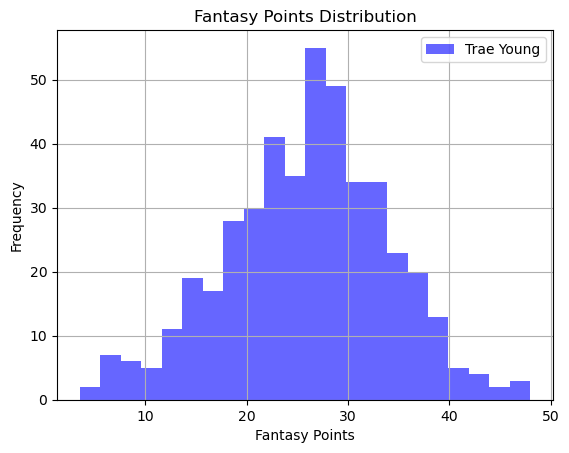

In [23]:
viz_player_distribution("Trae Young")

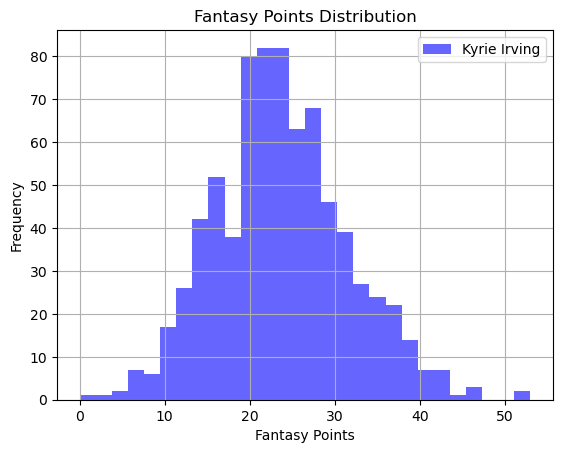

In [25]:
viz_player_distribution("Kyrie Irving")

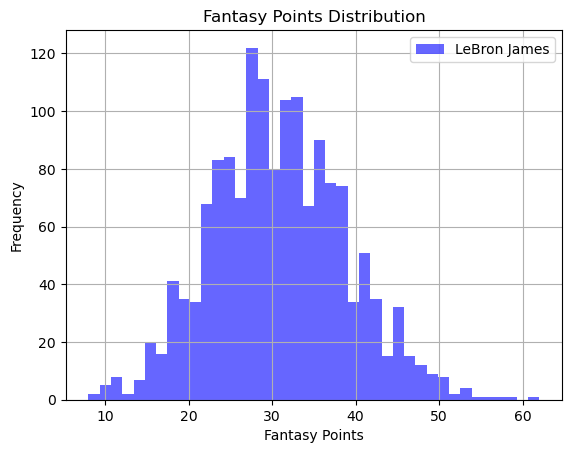

In [27]:
viz_player_distribution("LeBron James")

In [108]:
def basic_sampled_minimum_to_lock(games_remaining, player_name):

    assert(games_remaining > 0)
    
    num_games, all_fpts = get_all_fpts(player_name)
    all_fpts = np.array(all_fpts)
    
    mean = np.mean(all_fpts)
    std_dev = np.std(all_fpts)

    mins_required = np.zeros(games_remaining + 1)
    mins_required[1] = mean
    for i in range(2, games_remaining+1):
        
        sims = np.random.choice(all_fpts, min(200, num_games), replace=True)
        total = np.mean(np.maximum(sims, mins_required[i - 1]))
        mins_required[i] = total

    return mins_required

In [110]:
basic_sampled_minimum_to_lock(5, "Anthony Edwards")

array([ 0.        , 23.45588235, 26.16029412, 28.64127206, 29.82448585,
       31.17472139])

In [112]:
basic_sampled_minimum_to_lock(5, "Victor Wembanyama")

array([ 0.        , 33.66504854, 37.12051089, 38.95065831, 41.32179383,
       42.70658374])

In [114]:
basic_sampled_minimum_to_lock(5, "LeBron James")

array([ 0.        , 30.79803279, 33.90295738, 35.98998144, 37.35468553,
       38.30084213])

In [116]:
def should_lock(score, player_name, games_remaining):
    
    res = basic_sampled_minimum_to_lock(games_remaining, player_name)
    return (score > res[games_remaining])

In [118]:
should_lock(34.5, "Anthony Edwards", games_remaining=3)

True

In [120]:
should_lock(32.50, "Paolo Banchero", games_remaining=1)

True

In [122]:
should_lock(19.0, "Jaylen Brown", games_remaining=2)

False